# Imports

In [1]:
!pip install -q PyWavelets fastai

In [2]:
import os

import wfdb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from scipy.stats import zscore
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
        confusion_matrix, ConfusionMatrixDisplay,
        f1_score, multilabel_confusion_matrix, accuracy_score, classification_report)

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

import warnings
warnings.filterwarnings("ignore")

import pywt
from fastai.vision.all import *
from fastai.callback.all import *

In [3]:
print(torch.__version__)

2.0.0


# Preparing Data

In [4]:
!ls ../input/ptb-xl-100-hz
# !ls ../input/ptb-xl-lead-comparison

baseline_removed_100hz.npy


In [5]:
dataset_loc = "../input/ptb-xl-100-hz"

In [6]:
signals = np.load(os.path.join(dataset_loc, "baseline_removed_100hz.npy"))
signals.shape

(21388, 12, 1000)

In [7]:
faulty_index = 12498

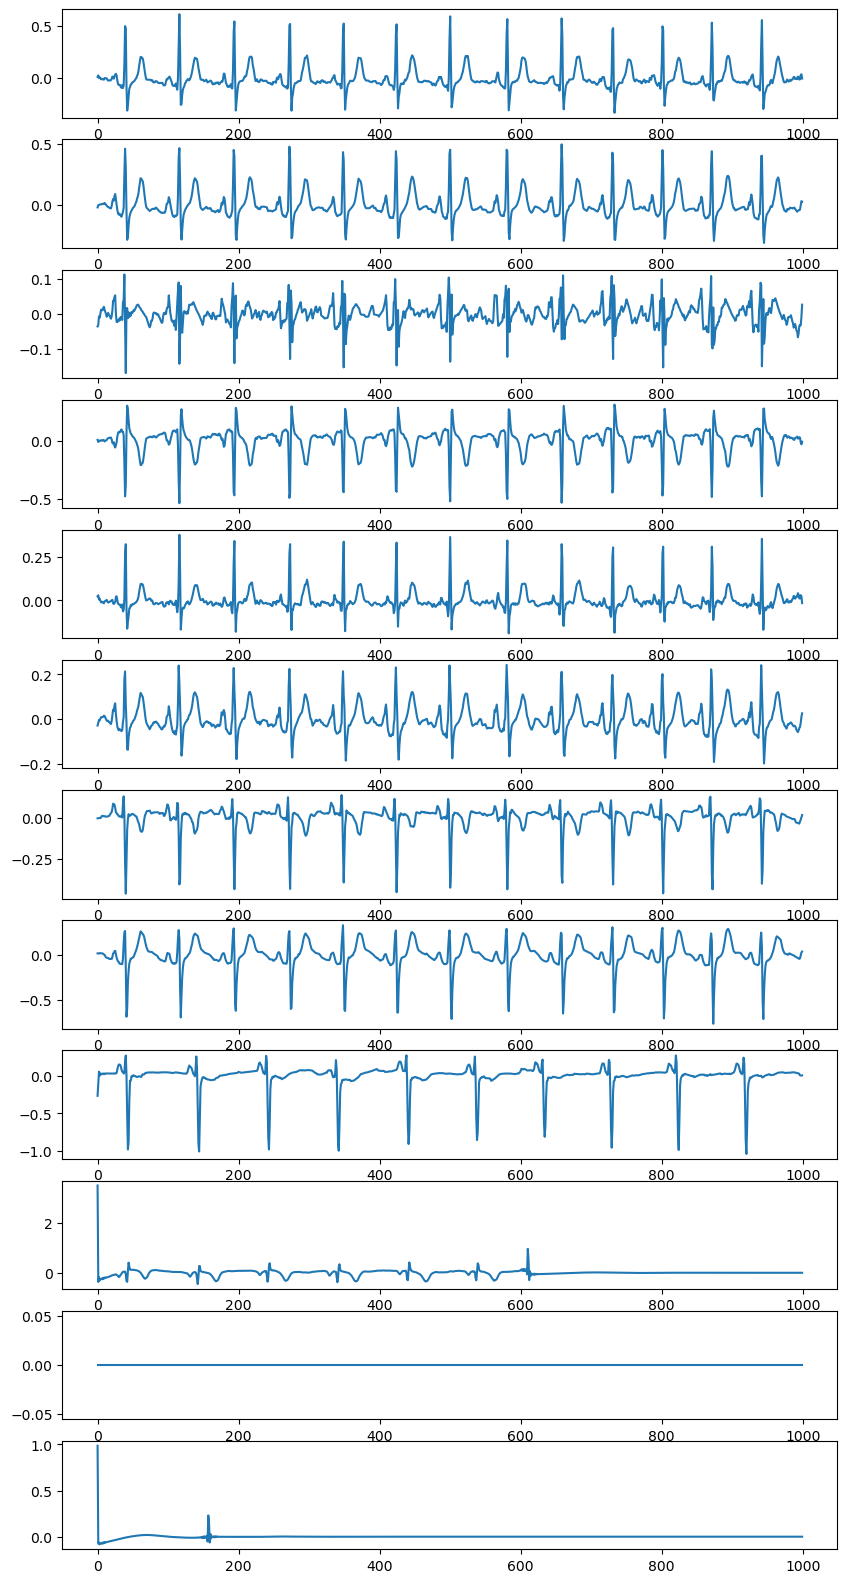

In [8]:
anomaly = signals[faulty_index]
fig, ax = plt.subplots(12, 1, figsize=(10, 20))
for i in range(12):
    ax[i].plot(anomaly[i])

In [9]:
signals = np.delete(signals, faulty_index, axis=0)
signals.shape

(21387, 12, 1000)

In [10]:
df = pd.read_csv("../input/ptb-xl-lead-comparison/labeled_df.csv")
df = df.drop(12498)
df = df.reset_index(drop=True)
df

,ecg_id,patient_id,age,sex,strat_fold,filename_lr,filename_hr,NORM,MI,STTC,CD,HYP
0,1,15709.0,56.0,1,3,records100/00000/00001_lr,records500/00000/00001_hr,1,0,0,0,0
1,2,13243.0,19.0,0,2,records100/00000/00002_lr,records500/00000/00002_hr,1,0,0,0,0
2,3,20372.0,37.0,1,5,records100/00000/00003_lr,records500/00000/00003_hr,1,0,0,0,0
3,4,17014.0,24.0,0,3,records100/00000/00004_lr,records500/00000/00004_hr,1,0,0,0,0
4,5,17448.0,19.0,1,4,records100/00000/00005_lr,records500/00000/00005_hr,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
21382,21833,17180.0,67.0,1,7,records100/21000/21833_lr,records500/21000/21833_hr,0,0,1,0,0
21383,21834,20703.0,300.0,0,4,records100/21000/21834_lr,records500/21000/21834_hr,1,0,0,0,0
21384,21835,19311.0,59.0,1,2,records100/21000/21835_lr,records500/21000/21835_hr,0,0,1,0,0
21385,21836,8873.0,64.0,1,8,records100/21000/21836_lr,records500/21000/21836_hr,1,0,0,0,0


In [11]:
classes = ['NORM', 'MI', 'STTC', 'CD', 'HYP']

In [12]:
classes2idx = {k:i for i, k in enumerate(classes)}
classes2idx

{'NORM': 0, 'MI': 1, 'STTC': 2, 'CD': 3, 'HYP': 4}

In [13]:
test_df = df[df['strat_fold'] == 10]
val_df = df[df['strat_fold'] == 9]
train_df = df[df['strat_fold'] <= 8]

In [14]:
test_signals = signals[test_df.index]
val_signals = signals[val_df.index]
train_signals = signals[train_df.index]

In [15]:
print(test_signals.shape)
print(val_signals.shape)
print(train_signals.shape)

(2158, 12, 1000)
(2146, 12, 1000)
(17083, 12, 1000)


In [16]:
# from the metadata of WFDB sample
leads = ['I','II','III','AVR','AVL','AVF','V1','V2','V3','V4','V5','V6']

leads_index = {l:i for i, l in enumerate(leads)}
leads_index

{'I': 0,
 'II': 1,
 'III': 2,
 'AVR': 3,
 'AVL': 4,
 'AVF': 5,
 'V1': 6,
 'V2': 7,
 'V3': 8,
 'V4': 9,
 'V5': 10,
 'V6': 11}

# PyTorch Dataset Class

In [17]:
def decompose(signal, level=3, **kwargs):
    lvl = kwargs.get("level", level)
    return pywt.wavedec(signal, 'db6', level=lvl)[0]

def minmax_norm(sig, **kwargs):
    s_min, s_max = sig.min(), sig.max()
    s_norm = (sig - s_min) / (s_max - s_min)
    return s_norm

In [18]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [19]:
class ECGDataset(Dataset):
    def __init__(self, df, signals, k, lead, transform=None, **kwargs):
        self.df = df
        self.signals = signals
        self.k = k
        self.lead = lead
        self.transform = transform
        self.kwargs = kwargs
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        instance = self.df.iloc[idx] # data instance
        label = instance[self.k]
        signal = self.signals[idx]
        
        channel = leads_index.get(self.lead, None)
        if channel is not None:
            signal = signal[channel][None, :]
            
        if self.transform:
            if type(self.transform) == list:
                for t in transform:
                    signal = t(signal, **self.kwargs)
            else:
                signal = self.transform(signal, self.kwargs)
        
        return torch.tensor(signal).float(), torch.tensor(label, dtype=torch.float32)

# Defining the architecture

In [20]:
class NeuralNetwork(nn.Module):
    def __init__(self, num_classes, num_channels, num_filters=64):
        super().__init__()
        n_filters = num_filters
        self.conv_1 = nn.Conv1d(num_channels, n_filters, 8, stride=1, padding='same')
        self.norm_1 = nn.BatchNorm1d(n_filters)
        self.conv_2 = nn.Conv1d(   n_filters, n_filters, 5, stride=1, padding='same')
        self.norm_2 = nn.BatchNorm1d(n_filters)
        self.conv_3 = nn.Conv1d(   n_filters, n_filters, 3, stride=1, padding='same')
        self.norm_3 = nn.BatchNorm1d(n_filters)
        self.conv_4 = nn.Conv1d(num_channels, n_filters, 1, stride=1, padding='same') # Expanding for addition
        self.norm_4 = nn.BatchNorm1d(n_filters)

        self.conv_5 = nn.Conv1d(  n_filters, n_filters*2, 8, stride=1, padding='same')
        self.norm_5 = nn.BatchNorm1d(n_filters*2)
        self.conv_6 = nn.Conv1d(n_filters*2, n_filters*2, 5, stride=1, padding='same')
        self.norm_6 = nn.BatchNorm1d(n_filters*2)
        self.conv_7 = nn.Conv1d(n_filters*2, n_filters*2, 3, stride=1, padding='same')
        self.norm_7 = nn.BatchNorm1d(n_filters*2)
        self.conv_8 = nn.Conv1d(  n_filters, n_filters*2, 1, stride=1, padding='same')
        self.norm_8 = nn.BatchNorm1d(n_filters*2)

        self.conv_9  = nn.Conv1d(n_filters*2, n_filters*2, 8, stride=1, padding='same')
        self.norm_9 = nn.BatchNorm1d(n_filters*2)
        self.conv_10 = nn.Conv1d(n_filters*2, n_filters*2, 5, stride=1, padding='same')
        self.norm_10 = nn.BatchNorm1d(n_filters*2)
        self.conv_11 = nn.Conv1d(n_filters*2, n_filters*2, 3, stride=1, padding='same')
        self.norm_11 = nn.BatchNorm1d(n_filters*2)
        self.conv_12 = nn.Conv1d(n_filters*2, n_filters*2, 1, stride=1, padding='same')
        self.norm_12 = nn.BatchNorm1d(n_filters*2)
        self.classifier = nn.Linear(n_filters*2, num_classes)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = x.float()
        
        # Block 1
        a = self.conv_1(x)
        a = self.norm_1(a)
        a = F.relu(a)
        
        b = self.conv_2(a)
        b = self.norm_2(b)
        b = F.relu(b)
        
        c = self.conv_3(b)
        c = self.norm_3(c)
        
        shortcut = self.conv_4(x)
        shortcut = self.norm_4(shortcut)
        
        output_1 = torch.add(c, shortcut)
        output_1 = F.relu(output_1)
        
        #Block 2
        a = self.conv_5(output_1)
        a = self.norm_5(a)
        a = F.relu(a)
        
        b = self.conv_6(a)
        b = self.norm_6(b)
        b = F.relu(b)
        
        c = self.conv_7(b)
        c = self.norm_7(c)
        shortcut = self.conv_8(output_1)
        shortcut = self.norm_8(shortcut)
        
        output_2 = torch.add(c, shortcut)
        output_2 = F.relu(output_2)
        
        #Block 3
        a = self.conv_9(output_2)
        a = self.norm_9(a)
        a = F.relu(a)
        
        b = self.conv_10(a)
        b = self.norm_10(b)
        b = F.relu(b)
        
        c = self.conv_11(b)
        c = self.norm_11(c)
        
#         shortcut = self.conv_12(output_2)
        shortcut = self.norm_12(shortcut)
        
        output_3 = torch.add(c, shortcut)
        output_3 = F.relu(output_3)
        
        logits = self.classifier(output_3.mean((2,)))
        res = self.sigmoid(logits)
        return res.squeeze()

# Training for individual classes

In [21]:
def create_data_splits(df, signals, BATCH_SIZE, k, lead, transform, **kwargs):
    test_df = df[df['strat_fold'] == 10]
    val_df = df[df['strat_fold'] == 9]
    train_df = df[df['strat_fold'] <= 8]
    
    test_signals = signals[test_df.index]
    val_signals = signals[val_df.index]
    train_signals = signals[train_df.index]
    
    train_dataset = ECGDataset(train_df, train_signals, k=k, lead=lead, transform=transform, **kwargs)
    val_dataset = ECGDataset(val_df, val_signals, k=k, lead=lead, transform=transform, **kwargs)
    test_dataset = ECGDataset(test_df, test_signals, k=k, lead=lead, transform=transform, **kwargs)
    
    train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)
    
    return train_dataloader, val_dataloader, test_dataloader

In [22]:
def create_leaner(train_dataloader, val_dataloader, num_channels):
    model = NeuralNetwork(num_classes=1, num_channels=num_channels, num_filters=64).to(device)
    dls = DataLoaders(train_dataloader, val_dataloader)
    loss_fn = nn.BCELoss()
    learn = Learner(
        dls,
        model,
        loss_func=loss_fn,    
        metrics=[F1ScoreMulti(sigmoid=False)]
    )
    
    return learn

In [23]:
def fit_and_test(learner, epochs, test_dataloader, model_name):
    learner.fit(
        epochs,
        lr=1e-3,
        cbs=[
            EarlyStoppingCallback(monitor='valid_loss', min_delta=0.001, patience=5),
            SaveModelCallback(monitor='f1_score', min_delta=0.001, fname=model_name)
        ]
    )
    
    learner.model.load_state_dict(
        torch.load(f"models/{model_name}.pth", map_location=torch.device(device)))
    learner.model.eval()
    
    y_pred = []
    y_true = []
    with torch.no_grad():
        for inputs, labels in tqdm(test_dataloader):
            output = learner.model(inputs.to(device).float())
            output = (output > 0.5).int()
            y_pred.extend(output)
            labels = labels.data.cpu().int().numpy()
            y_true.extend(labels)
    y_true = torch.tensor(y_true).cpu()
    y_pred = torch.stack(y_pred).cpu()
    
    return y_true, y_pred

In [24]:
def evaluate_model(k, y_true, y_pred):
    print(f"Performing evaluation for class {k}")
    res = classification_report(y_true, y_pred)
    print(res)
    
#     ConfusionMatrixDisplay.from_predictions(
#         y_true, y_pred, 
#         colorbar=True
#     )

In [25]:
def full_loop(k, ecg_leads):
    print(f"Using {ecg_leads} lead(s)")
    loaders = create_data_splits(df, signals, BATCH_SIZE, k, ecg_leads, transform, **kwargs)
    train_dataloader, val_dataloader, test_dataloader = loaders
    
    for X, y in test_dataloader:
        test_shape = X.shape
        break

    num_channels = X.shape[1]
    learn = create_leaner(train_dataloader, val_dataloader, num_channels)
    y_true, y_pred = fit_and_test(learn, num_epochs, test_dataloader, f"model_for_{k}-{ecg_leads}")
    evaluate_model(k, y_true, y_pred)
    
    return learn

In [26]:
# params
BATCH_SIZE = 32
transform = []
kwargs = {}
num_epochs = 20

In [27]:
import gc

In [28]:
def train_test_lead(lead):
    for c in classes:
        full_loop(c, ecg_leads=lead)
        gc.collect()

# For Lead-I

In [29]:
train_test_lead("I")

Using I lead(s)


epoch,train_loss,valid_loss,f1_score,time
0,0.444111,0.436374,0.800334,00:23
1,0.437653,0.439750,0.783571,00:17
2,0.432408,0.432530,0.800651,00:17
3,0.419250,0.444714,0.798229,00:17
4,0.437445,0.417747,0.799878,00:17
5,0.422416,0.418102,0.804432,00:17
6,0.428408,0.426554,0.802354,00:17
7,0.399352,0.427850,0.793046,00:17
8,0.413801,0.415630,0.801757,00:17
9,0.416934,0.426968,0.805170,00:17


Better model found at epoch 0 with f1_score value: 0.8003344251860599.
Better model found at epoch 5 with f1_score value: 0.804431605305816.
Better model found at epoch 11 with f1_score value: 0.806187657980268.
No improvement since epoch 8: early stopping


  0%|          | 0/68 [00:00<?, ?it/s]

Performing evaluation for class NORM
              precision    recall  f1-score   support

           0       0.88      0.75      0.81      1195
           1       0.74      0.88      0.80       963

    accuracy                           0.81      2158
   macro avg       0.81      0.81      0.81      2158
weighted avg       0.82      0.81      0.81      2158

Using I lead(s)


epoch,train_loss,valid_loss,f1_score,time
0,0.488218,0.478130,0.622748,00:17
1,0.490335,0.472194,0.636051,00:17
2,0.483006,0.458003,0.678751,00:17
3,0.483847,0.458760,0.684486,00:17
4,0.479746,0.473981,0.702407,00:17
5,0.476977,0.481894,0.597937,00:17
6,0.472167,0.461490,0.683730,00:17
7,0.465932,0.473528,0.613354,00:17


Better model found at epoch 0 with f1_score value: 0.6227478547227763.
Better model found at epoch 1 with f1_score value: 0.6360511128718143.
Better model found at epoch 2 with f1_score value: 0.6787509891849116.
Better model found at epoch 3 with f1_score value: 0.6844859825379936.
Better model found at epoch 4 with f1_score value: 0.7024067650605342.
No improvement since epoch 2: early stopping


  0%|          | 0/68 [00:00<?, ?it/s]

Performing evaluation for class MI
              precision    recall  f1-score   support

           0       0.82      0.88      0.85      1608
           1       0.57      0.45      0.50       550

    accuracy                           0.77      2158
   macro avg       0.70      0.67      0.68      2158
weighted avg       0.76      0.77      0.76      2158

Using I lead(s)


epoch,train_loss,valid_loss,f1_score,time
0,0.395291,0.402744,0.758209,00:17
1,0.399901,0.409613,0.737673,00:17
2,0.368496,0.394254,0.753307,00:17
3,0.390801,0.376913,0.756334,00:17
4,0.364267,0.389090,0.726999,00:17
5,0.372333,0.379269,0.745115,00:17
6,0.373679,0.376241,0.751459,00:17
7,0.373172,0.377585,0.748261,00:17
8,0.366435,0.389402,0.722207,00:17


Better model found at epoch 0 with f1_score value: 0.7582091817672333.
No improvement since epoch 3: early stopping


  0%|          | 0/68 [00:00<?, ?it/s]

Performing evaluation for class STTC
              precision    recall  f1-score   support

           0       0.89      0.89      0.89      1637
           1       0.65      0.64      0.65       521

    accuracy                           0.83      2158
   macro avg       0.77      0.77      0.77      2158
weighted avg       0.83      0.83      0.83      2158

Using I lead(s)


epoch,train_loss,valid_loss,f1_score,time
0,0.401554,0.413399,0.713278,00:17
1,0.398402,0.449767,0.678462,00:17
2,0.382705,0.388017,0.729996,00:17
3,0.391964,0.398876,0.723412,00:17
4,0.390839,0.381504,0.738796,00:17
5,0.373973,0.385529,0.741494,00:17
6,0.375272,0.382135,0.728415,00:17
7,0.376905,0.381250,0.727714,00:17
8,0.373856,0.378889,0.725779,00:17
9,0.366316,0.389824,0.725986,00:17


Better model found at epoch 0 with f1_score value: 0.7132775538811985.
Better model found at epoch 2 with f1_score value: 0.7299962026069332.
Better model found at epoch 4 with f1_score value: 0.7387963328280025.
Better model found at epoch 5 with f1_score value: 0.741494447581404.
Better model found at epoch 11 with f1_score value: 0.7481393097107985.
No improvement since epoch 14: early stopping


  0%|          | 0/68 [00:00<?, ?it/s]

Performing evaluation for class CD
              precision    recall  f1-score   support

           0       0.86      0.95      0.90      1662
           1       0.74      0.48      0.58       496

    accuracy                           0.84      2158
   macro avg       0.80      0.72      0.74      2158
weighted avg       0.83      0.84      0.83      2158

Using I lead(s)


epoch,train_loss,valid_loss,f1_score,time
0,0.312088,0.319025,0.619006,00:17
1,0.304637,0.330511,0.626265,00:17
2,0.325588,0.314080,0.604400,00:17
3,0.308320,0.316889,0.620429,00:17
4,0.307976,0.310959,0.616811,00:17
5,0.302617,0.311183,0.624588,00:17
6,0.314736,0.321402,0.649439,00:17
7,0.311583,0.310852,0.630774,00:17
8,0.288587,0.323236,0.654136,00:17
9,0.297112,0.315170,0.643331,00:17


Better model found at epoch 0 with f1_score value: 0.6190059733888188.
Better model found at epoch 1 with f1_score value: 0.6262647258754066.
Better model found at epoch 6 with f1_score value: 0.6494389364295498.
Better model found at epoch 8 with f1_score value: 0.6541357933107002.
No improvement since epoch 4: early stopping


  0%|          | 0/68 [00:00<?, ?it/s]

Performing evaluation for class HYP
              precision    recall  f1-score   support

           0       0.92      0.96      0.94      1896
           1       0.55      0.38      0.45       262

    accuracy                           0.89      2158
   macro avg       0.73      0.67      0.69      2158
weighted avg       0.87      0.89      0.88      2158



# For Lead-II

In [30]:
train_test_lead("II")

Using II lead(s)


epoch,train_loss,valid_loss,f1_score,time
0,0.441396,0.420392,0.803816,00:17
1,0.406177,0.404864,0.818765,00:17
2,0.419036,0.405641,0.820694,00:17
3,0.383653,0.401312,0.819134,00:17
4,0.390621,0.394553,0.824460,00:17
5,0.387519,0.397906,0.820461,00:17
6,0.394774,0.391685,0.830115,00:17
7,0.370060,0.398231,0.817129,00:17
8,0.388256,0.407214,0.818215,00:17
9,0.380108,0.385906,0.823883,00:17


Better model found at epoch 0 with f1_score value: 0.8038159079040085.
Better model found at epoch 1 with f1_score value: 0.8187648274312467.
Better model found at epoch 2 with f1_score value: 0.8206939685921788.
Better model found at epoch 4 with f1_score value: 0.8244596902317314.
Better model found at epoch 6 with f1_score value: 0.8301147001320486.
Better model found at epoch 13 with f1_score value: 0.8319658999923008.
No improvement since epoch 13: early stopping


  0%|          | 0/68 [00:00<?, ?it/s]

Performing evaluation for class NORM
              precision    recall  f1-score   support

           0       0.88      0.78      0.83      1195
           1       0.76      0.87      0.81       963

    accuracy                           0.82      2158
   macro avg       0.82      0.83      0.82      2158
weighted avg       0.83      0.82      0.82      2158

Using II lead(s)


epoch,train_loss,valid_loss,f1_score,time
0,0.462508,0.428624,0.707136,00:17
1,0.439940,0.422059,0.695528,00:17
2,0.457108,0.441595,0.709370,00:17
3,0.424985,0.417551,0.711755,00:17
4,0.429438,0.416344,0.679447,00:17
5,0.433263,0.414353,0.697931,00:17
6,0.417173,0.412539,0.688451,00:17
7,0.421752,0.410149,0.700732,00:17
8,0.411301,0.408534,0.710591,00:17
9,0.427835,0.409326,0.684715,00:17


Better model found at epoch 0 with f1_score value: 0.7071357842888336.
Better model found at epoch 2 with f1_score value: 0.7093696876139425.
Better model found at epoch 3 with f1_score value: 0.7117548919805452.
Better model found at epoch 10 with f1_score value: 0.7177745630321978.
No improvement since epoch 8: early stopping


  0%|          | 0/68 [00:00<?, ?it/s]

Performing evaluation for class MI
              precision    recall  f1-score   support

           0       0.82      0.95      0.88      1608
           1       0.73      0.39      0.50       550

    accuracy                           0.81      2158
   macro avg       0.77      0.67      0.69      2158
weighted avg       0.80      0.81      0.78      2158

Using II lead(s)


epoch,train_loss,valid_loss,f1_score,time
0,0.399522,0.397195,0.699527,00:17
1,0.375186,0.388000,0.759972,00:17
2,0.366104,0.374533,0.755428,00:17
3,0.349044,0.389521,0.716887,00:17
4,0.344428,0.388972,0.698183,00:17
5,0.357000,0.368644,0.755996,00:17
6,0.339860,0.373652,0.738924,00:17
7,0.350888,0.369332,0.758704,00:17
8,0.362580,0.383326,0.771946,00:17
9,0.350334,0.369656,0.748155,00:17


Better model found at epoch 0 with f1_score value: 0.6995274224468547.
Better model found at epoch 1 with f1_score value: 0.7599718647663853.
Better model found at epoch 8 with f1_score value: 0.7719457876518361.
No improvement since epoch 13: early stopping


  0%|          | 0/68 [00:00<?, ?it/s]

Performing evaluation for class STTC
              precision    recall  f1-score   support

           0       0.90      0.89      0.89      1637
           1       0.66      0.68      0.67       521

    accuracy                           0.84      2158
   macro avg       0.78      0.78      0.78      2158
weighted avg       0.84      0.84      0.84      2158

Using II lead(s)


epoch,train_loss,valid_loss,f1_score,time
0,0.349821,0.364659,0.757448,00:17
1,0.361866,0.365172,0.738094,00:17
2,0.327455,0.336738,0.782533,00:17
3,0.326846,0.326377,0.794068,00:17
4,0.337132,0.336885,0.791866,00:17
5,0.328491,0.320759,0.803633,00:17
6,0.311119,0.321156,0.792786,00:17
7,0.304911,0.313498,0.803613,00:17
8,0.300323,0.314573,0.809314,00:17
9,0.307546,0.322678,0.808949,00:17


Better model found at epoch 0 with f1_score value: 0.7574476644021881.
Better model found at epoch 2 with f1_score value: 0.7825325138277199.
Better model found at epoch 3 with f1_score value: 0.7940680975335992.
Better model found at epoch 5 with f1_score value: 0.803633073615921.
Better model found at epoch 8 with f1_score value: 0.8093137848863039.
Better model found at epoch 12 with f1_score value: 0.8121237402217518.
Better model found at epoch 13 with f1_score value: 0.8174744930976973.
No improvement since epoch 13: early stopping


  0%|          | 0/68 [00:00<?, ?it/s]

Performing evaluation for class CD
              precision    recall  f1-score   support

           0       0.88      0.96      0.92      1662
           1       0.79      0.56      0.66       496

    accuracy                           0.87      2158
   macro avg       0.84      0.76      0.79      2158
weighted avg       0.86      0.87      0.86      2158

Using II lead(s)


epoch,train_loss,valid_loss,f1_score,time
0,0.348152,0.334290,0.555498,00:17
1,0.341352,0.343700,0.520180,00:17
2,0.311754,0.322081,0.574687,00:17
3,0.305998,0.320105,0.589372,00:17
4,0.309035,0.321888,0.620151,00:17
5,0.298229,0.316586,0.593975,00:17
6,0.295282,0.319400,0.572223,00:17
7,0.303190,0.324438,0.608709,00:17
8,0.298044,0.317857,0.561449,00:17
9,0.285781,0.313782,0.566443,00:17


Better model found at epoch 0 with f1_score value: 0.5554978870305338.
Better model found at epoch 2 with f1_score value: 0.5746869071357034.
Better model found at epoch 3 with f1_score value: 0.5893716025222874.
Better model found at epoch 4 with f1_score value: 0.620150860269566.
No improvement since epoch 11: early stopping


  0%|          | 0/68 [00:00<?, ?it/s]

Performing evaluation for class HYP
              precision    recall  f1-score   support

           0       0.90      0.96      0.93      1896
           1       0.47      0.26      0.33       262

    accuracy                           0.87      2158
   macro avg       0.68      0.61      0.63      2158
weighted avg       0.85      0.87      0.86      2158



# For Lead-III

In [31]:
train_test_lead("III")

Using III lead(s)


epoch,train_loss,valid_loss,f1_score,time
0,0.550879,0.570269,0.680843,00:17
1,0.512558,0.521162,0.730194,00:17
2,0.515025,0.506824,0.736424,00:17
3,0.513314,0.538515,0.709788,00:17
4,0.496306,0.508849,0.734749,00:17
5,0.498450,0.500946,0.749322,00:17
6,0.492544,0.498873,0.752100,00:17
7,0.481905,0.506585,0.744171,00:17
8,0.464645,0.510938,0.743074,00:17
9,0.476046,0.486316,0.758660,00:17


Better model found at epoch 0 with f1_score value: 0.6808429720763179.
Better model found at epoch 1 with f1_score value: 0.7301942483113446.
Better model found at epoch 2 with f1_score value: 0.7364242486229525.
Better model found at epoch 5 with f1_score value: 0.7493220984105734.
Better model found at epoch 6 with f1_score value: 0.7520995677376596.
Better model found at epoch 9 with f1_score value: 0.7586602597067953.
Better model found at epoch 12 with f1_score value: 0.7600185872193326.
No improvement since epoch 9: early stopping


  0%|          | 0/68 [00:00<?, ?it/s]

Performing evaluation for class NORM
              precision    recall  f1-score   support

           0       0.81      0.69      0.75      1195
           1       0.67      0.80      0.73       963

    accuracy                           0.74      2158
   macro avg       0.74      0.74      0.74      2158
weighted avg       0.75      0.74      0.74      2158

Using III lead(s)


epoch,train_loss,valid_loss,f1_score,time
0,0.457070,0.462308,0.667627,00:17
1,0.449899,0.441879,0.673776,00:17
2,0.436341,0.434536,0.713168,00:17
3,0.435668,0.430434,0.697133,00:17
4,0.428164,0.425528,0.719316,00:17
5,0.404412,0.441133,0.670065,00:17
6,0.434145,0.420376,0.687016,00:17
7,0.426591,0.431438,0.665374,00:17
8,0.402667,0.431394,0.654805,00:17
9,0.405880,0.422590,0.704890,00:17


Better model found at epoch 0 with f1_score value: 0.6676270638312749.
Better model found at epoch 1 with f1_score value: 0.6737758995485156.
Better model found at epoch 2 with f1_score value: 0.7131679911196118.
Better model found at epoch 4 with f1_score value: 0.7193160362362028.
No improvement since epoch 6: early stopping


  0%|          | 0/68 [00:00<?, ?it/s]

Performing evaluation for class MI
              precision    recall  f1-score   support

           0       0.83      0.92      0.87      1608
           1       0.66      0.44      0.53       550

    accuracy                           0.80      2158
   macro avg       0.75      0.68      0.70      2158
weighted avg       0.79      0.80      0.79      2158

Using III lead(s)


epoch,train_loss,valid_loss,f1_score,time
0,0.545390,0.537565,0.437507,00:17
1,0.531220,0.549687,0.445344,00:17
2,0.525220,0.531148,0.442867,00:17
3,0.518056,0.549998,0.564485,00:17
4,0.514562,0.522374,0.547746,00:17
5,0.497186,0.521358,0.544801,00:17
6,0.502484,0.536101,0.587393,00:17
7,0.523550,0.518788,0.521663,00:17
8,0.504903,0.530832,0.565653,00:17
9,0.499532,0.520698,0.525310,00:17


Better model found at epoch 0 with f1_score value: 0.4375066026434493.
Better model found at epoch 1 with f1_score value: 0.44534404937088173.
Better model found at epoch 3 with f1_score value: 0.564484532687592.
Better model found at epoch 6 with f1_score value: 0.5873927585962007.
Better model found at epoch 11 with f1_score value: 0.5970631462405553.
Better model found at epoch 15 with f1_score value: 0.6009122912687761.
No improvement since epoch 11: early stopping


  0%|          | 0/68 [00:00<?, ?it/s]

Performing evaluation for class STTC
              precision    recall  f1-score   support

           0       0.80      0.91      0.85      1637
           1       0.48      0.27      0.35       521

    accuracy                           0.75      2158
   macro avg       0.64      0.59      0.60      2158
weighted avg       0.72      0.75      0.73      2158

Using III lead(s)


epoch,train_loss,valid_loss,f1_score,time
0,0.420483,0.405877,0.691747,00:17
1,0.425180,0.415823,0.711781,00:17
2,0.382496,0.386143,0.731004,00:17
3,0.398250,0.394113,0.675738,00:17
4,0.386443,0.398942,0.695351,00:17
5,0.397871,0.386103,0.754736,00:17
6,0.377983,0.383501,0.722698,00:17
7,0.369863,0.366881,0.749045,00:17
8,0.364934,0.364478,0.745546,00:17
9,0.366345,0.368474,0.746203,00:17


Better model found at epoch 0 with f1_score value: 0.6917474148671919.
Better model found at epoch 1 with f1_score value: 0.7117805798645189.
Better model found at epoch 2 with f1_score value: 0.7310043629710425.
Better model found at epoch 5 with f1_score value: 0.7547359725385775.
No improvement since epoch 8: early stopping


  0%|          | 0/68 [00:00<?, ?it/s]

Performing evaluation for class CD
              precision    recall  f1-score   support

           0       0.87      0.92      0.89      1662
           1       0.67      0.52      0.59       496

    accuracy                           0.83      2158
   macro avg       0.77      0.72      0.74      2158
weighted avg       0.82      0.83      0.82      2158

Using III lead(s)


epoch,train_loss,valid_loss,f1_score,time
0,0.337572,0.360950,0.510701,00:17
1,0.330531,0.367099,0.545090,00:17
2,0.346981,0.355652,0.481126,00:17
3,0.344604,0.355759,0.508422,00:17
4,0.327278,0.352809,0.521338,00:17
5,0.345266,0.350505,0.530863,00:17
6,0.333620,0.348400,0.514352,00:17
7,0.318983,0.350388,0.521338,00:17
8,0.342275,0.350743,0.527803,00:17
9,0.333790,0.346017,0.500750,00:17


Better model found at epoch 0 with f1_score value: 0.5107009286956404.
Better model found at epoch 1 with f1_score value: 0.545090317932702.
Better model found at epoch 13 with f1_score value: 0.5526495917960972.
No improvement since epoch 10: early stopping


  0%|          | 0/68 [00:00<?, ?it/s]

Performing evaluation for class HYP
              precision    recall  f1-score   support

           0       0.89      0.98      0.93      1896
           1       0.45      0.11      0.18       262

    accuracy                           0.88      2158
   macro avg       0.67      0.55      0.56      2158
weighted avg       0.84      0.88      0.84      2158



# For Lead-AVR

In [32]:
train_test_lead("AVR")

Using AVR lead(s)


epoch,train_loss,valid_loss,f1_score,time
0,0.409637,0.412053,0.813264,00:17
1,0.385046,0.424672,0.809799,00:17
2,0.396217,0.398935,0.810067,00:17
3,0.388222,0.390750,0.821178,00:17
4,0.391098,0.387819,0.819181,00:17
5,0.379523,0.391169,0.819615,00:17
6,0.364689,0.384751,0.825263,00:17
7,0.375845,0.393054,0.823534,00:17
8,0.371193,0.386976,0.825453,00:17
9,0.378332,0.402409,0.808962,00:17


Better model found at epoch 0 with f1_score value: 0.8132635116379643.
Better model found at epoch 3 with f1_score value: 0.8211779889480453.
Better model found at epoch 6 with f1_score value: 0.8252631707283089.
Better model found at epoch 11 with f1_score value: 0.8306927639553314.


  0%|          | 0/68 [00:00<?, ?it/s]

Performing evaluation for class NORM
              precision    recall  f1-score   support

           0       0.91      0.76      0.83      1195
           1       0.75      0.90      0.82       963

    accuracy                           0.82      2158
   macro avg       0.83      0.83      0.82      2158
weighted avg       0.84      0.82      0.82      2158

Using AVR lead(s)


epoch,train_loss,valid_loss,f1_score,time
0,0.464223,0.441801,0.697688,00:17
1,0.453085,0.448953,0.700789,00:17
2,0.447702,0.431241,0.695811,00:17
3,0.446704,0.439068,0.686663,00:17
4,0.439504,0.442576,0.691095,00:17
5,0.440710,0.430438,0.686205,00:17
6,0.429420,0.437818,0.661728,00:17
7,0.425397,0.441803,0.671023,00:17


Better model found at epoch 0 with f1_score value: 0.6976884164692322.
Better model found at epoch 1 with f1_score value: 0.7007887071307717.
No improvement since epoch 2: early stopping


  0%|          | 0/68 [00:00<?, ?it/s]

Performing evaluation for class MI
              precision    recall  f1-score   support

           0       0.82      0.91      0.86      1608
           1       0.62      0.44      0.51       550

    accuracy                           0.79      2158
   macro avg       0.72      0.67      0.69      2158
weighted avg       0.77      0.79      0.77      2158

Using AVR lead(s)


epoch,train_loss,valid_loss,f1_score,time
0,0.358881,0.365316,0.691007,00:17
1,0.346664,0.351195,0.746355,00:17
2,0.344133,0.346019,0.779087,00:17
3,0.334321,0.339626,0.791505,00:17
4,0.330775,0.338926,0.780273,00:17
5,0.330531,0.331540,0.798461,00:17
6,0.329367,0.332262,0.781560,00:17
7,0.330362,0.335114,0.769381,00:17
8,0.328438,0.342143,0.787169,00:17
9,0.319775,0.344753,0.756170,00:17


Better model found at epoch 0 with f1_score value: 0.6910065622600238.
Better model found at epoch 1 with f1_score value: 0.7463549121835527.
Better model found at epoch 2 with f1_score value: 0.7790866061673993.
Better model found at epoch 3 with f1_score value: 0.7915051316627336.
Better model found at epoch 5 with f1_score value: 0.7984609391085888.
Better model found at epoch 10 with f1_score value: 0.8026167087242748.
No improvement since epoch 5: early stopping


  0%|          | 0/68 [00:00<?, ?it/s]

Performing evaluation for class STTC
              precision    recall  f1-score   support

           0       0.89      0.94      0.91      1637
           1       0.76      0.65      0.70       521

    accuracy                           0.87      2158
   macro avg       0.83      0.79      0.81      2158
weighted avg       0.86      0.87      0.86      2158

Using AVR lead(s)


epoch,train_loss,valid_loss,f1_score,time
0,0.348891,0.370373,0.769470,00:17
1,0.353029,0.353604,0.773766,00:17
2,0.349807,0.349811,0.782413,00:17
3,0.342835,0.360119,0.782445,00:17
4,0.335189,0.424111,0.761359,00:17
5,0.341004,0.347748,0.774470,00:17
6,0.329160,0.366457,0.752607,00:17
7,0.335091,0.339258,0.787837,00:17
8,0.333855,0.338311,0.779706,00:17
9,0.337707,0.340219,0.779341,00:17


Better model found at epoch 0 with f1_score value: 0.7694699435394656.
Better model found at epoch 1 with f1_score value: 0.7737655346536371.
Better model found at epoch 2 with f1_score value: 0.7824125018184458.
Better model found at epoch 7 with f1_score value: 0.7878365408147157.
No improvement since epoch 7: early stopping


  0%|          | 0/68 [00:00<?, ?it/s]

Performing evaluation for class CD
              precision    recall  f1-score   support

           0       0.88      0.94      0.91      1662
           1       0.73      0.59      0.65       496

    accuracy                           0.86      2158
   macro avg       0.81      0.76      0.78      2158
weighted avg       0.85      0.86      0.85      2158

Using AVR lead(s)


epoch,train_loss,valid_loss,f1_score,time
0,0.305437,0.315277,0.593457,00:17
1,0.292167,0.311118,0.600040,00:17
2,0.278803,0.310965,0.578381,00:17
3,0.295135,0.322398,0.536261,00:17
4,0.273270,0.330572,0.580796,00:17
5,0.293834,0.304050,0.660225,00:17
6,0.266683,0.323811,0.589049,00:17
7,0.272150,0.310496,0.583240,00:17
8,0.297039,0.295444,0.634957,00:17
9,0.288959,0.295189,0.615922,00:17


Better model found at epoch 0 with f1_score value: 0.5934568006338264.
Better model found at epoch 1 with f1_score value: 0.6000404961701207.
Better model found at epoch 5 with f1_score value: 0.6602254306932559.


  0%|          | 0/68 [00:00<?, ?it/s]

Performing evaluation for class HYP
              precision    recall  f1-score   support

           0       0.91      0.96      0.94      1896
           1       0.56      0.33      0.42       262

    accuracy                           0.89      2158
   macro avg       0.74      0.65      0.68      2158
weighted avg       0.87      0.89      0.87      2158



# For Lead-AVL

In [33]:
train_test_lead("AVL")

Using AVL lead(s)


epoch,train_loss,valid_loss,f1_score,time
0,0.505755,0.640601,0.653514,00:17
1,0.492070,0.476568,0.751825,00:17
2,0.503213,0.486389,0.752147,00:17
3,0.484580,0.491102,0.755010,00:17
4,0.476984,0.537477,0.715034,00:17
5,0.468539,0.467267,0.768349,00:17
6,0.453354,0.494964,0.750277,00:17
7,0.474519,0.481649,0.765488,00:17
8,0.455387,0.478303,0.760012,00:17
9,0.466559,0.475276,0.768375,00:17


Better model found at epoch 0 with f1_score value: 0.6535139300992114.
Better model found at epoch 1 with f1_score value: 0.7518252244792533.
Better model found at epoch 3 with f1_score value: 0.7550097798208428.
Better model found at epoch 5 with f1_score value: 0.768348991232041.
No improvement since epoch 5: early stopping


  0%|          | 0/68 [00:00<?, ?it/s]

Performing evaluation for class NORM
              precision    recall  f1-score   support

           0       0.80      0.75      0.78      1195
           1       0.71      0.76      0.74       963

    accuracy                           0.76      2158
   macro avg       0.76      0.76      0.76      2158
weighted avg       0.76      0.76      0.76      2158

Using AVL lead(s)


epoch,train_loss,valid_loss,f1_score,time
0,0.488299,0.521719,0.699844,00:17
1,0.467066,0.478153,0.589764,00:17
2,0.461513,0.468769,0.626411,00:17
3,0.457096,0.460274,0.685072,00:17
4,0.453096,0.483559,0.565269,00:17
5,0.450253,0.467429,0.613589,00:17
6,0.447808,0.454293,0.673381,00:17
7,0.448040,0.454097,0.687946,00:17
8,0.463845,0.478283,0.689688,00:17
9,0.459686,0.454138,0.705659,00:17


Better model found at epoch 0 with f1_score value: 0.6998441805840685.
Better model found at epoch 9 with f1_score value: 0.7056593914983944.


  0%|          | 0/68 [00:00<?, ?it/s]

Performing evaluation for class MI
              precision    recall  f1-score   support

           0       0.83      0.88      0.86      1608
           1       0.58      0.48      0.53       550

    accuracy                           0.78      2158
   macro avg       0.71      0.68      0.69      2158
weighted avg       0.77      0.78      0.77      2158

Using AVL lead(s)


epoch,train_loss,valid_loss,f1_score,time
0,0.490689,0.498315,0.512032,00:17
1,0.486059,0.502141,0.523873,00:17
2,0.476834,0.483217,0.648237,00:17
3,0.466792,0.507201,0.527424,00:17
4,0.467299,0.472133,0.644461,00:17
5,0.460593,0.473039,0.606080,00:17
6,0.446826,0.475257,0.629222,00:17
7,0.455952,0.484859,0.563122,00:17
8,0.469909,0.473455,0.578015,00:17
9,0.453254,0.465091,0.666565,00:17


Better model found at epoch 0 with f1_score value: 0.5120317416833815.
Better model found at epoch 1 with f1_score value: 0.5238725333923795.
Better model found at epoch 2 with f1_score value: 0.6482368984999026.
Better model found at epoch 9 with f1_score value: 0.6665652779039651.
No improvement since epoch 9: early stopping


  0%|          | 0/68 [00:00<?, ?it/s]

Performing evaluation for class STTC
              precision    recall  f1-score   support

           0       0.82      0.90      0.86      1637
           1       0.55      0.39      0.46       521

    accuracy                           0.77      2158
   macro avg       0.68      0.64      0.66      2158
weighted avg       0.76      0.77      0.76      2158

Using AVL lead(s)


epoch,train_loss,valid_loss,f1_score,time
0,0.413757,0.424760,0.700541,00:17
1,0.410328,0.412412,0.713527,00:17
2,0.410548,0.394351,0.712605,00:17
3,0.415852,0.394102,0.706560,00:17
4,0.398293,0.394357,0.704013,00:17
5,0.375585,0.407129,0.698298,00:17
6,0.378625,0.382097,0.721919,00:17
7,0.381143,0.432543,0.667626,00:17
8,0.375283,0.373676,0.728242,00:17
9,0.387186,0.380109,0.743859,00:17


Better model found at epoch 0 with f1_score value: 0.7005412428913258.
Better model found at epoch 1 with f1_score value: 0.7135268389053682.
Better model found at epoch 6 with f1_score value: 0.7219193494572345.
Better model found at epoch 8 with f1_score value: 0.7282418493276845.
Better model found at epoch 9 with f1_score value: 0.7438587716406544.
No improvement since epoch 8: early stopping


  0%|          | 0/68 [00:00<?, ?it/s]

Performing evaluation for class CD
              precision    recall  f1-score   support

           0       0.86      0.94      0.90      1662
           1       0.71      0.47      0.56       496

    accuracy                           0.83      2158
   macro avg       0.78      0.71      0.73      2158
weighted avg       0.82      0.83      0.82      2158

Using AVL lead(s)


epoch,train_loss,valid_loss,f1_score,time
0,0.348391,0.343332,0.545663,00:17
1,0.336408,0.337677,0.513003,00:17
2,0.319264,0.335847,0.574715,00:17
3,0.336710,0.335420,0.547245,00:17
4,0.317463,0.336578,0.592482,00:17
5,0.324536,0.332554,0.591141,00:17
6,0.312580,0.326934,0.542929,00:17
7,0.318761,0.337435,0.599170,00:17
8,0.333244,0.330241,0.545243,00:17
9,0.316608,0.335046,0.513589,00:17


Better model found at epoch 0 with f1_score value: 0.5456632198252808.
Better model found at epoch 2 with f1_score value: 0.5747154846280425.
Better model found at epoch 4 with f1_score value: 0.5924824237153006.
Better model found at epoch 7 with f1_score value: 0.5991698060790531.
No improvement since epoch 6: early stopping


  0%|          | 0/68 [00:00<?, ?it/s]

Performing evaluation for class HYP
              precision    recall  f1-score   support

           0       0.90      0.96      0.93      1896
           1       0.47      0.23      0.31       262

    accuracy                           0.88      2158
   macro avg       0.69      0.60      0.62      2158
weighted avg       0.85      0.88      0.86      2158



# For Lead-AVF

In [34]:
train_test_lead("AVF")

Using AVF lead(s)


epoch,train_loss,valid_loss,f1_score,time
0,0.488209,0.625543,0.577420,00:17
1,0.470952,0.472245,0.771194,00:17
2,0.459311,0.450099,0.783157,00:17
3,0.439604,0.454011,0.781136,00:17
4,0.444603,0.443187,0.789410,00:17
5,0.450382,0.454620,0.784403,00:17
6,0.420778,0.469594,0.771244,00:17
7,0.441429,0.450140,0.783451,00:17
8,0.424858,0.446535,0.786401,00:17
9,0.431851,0.436585,0.794453,00:17


Better model found at epoch 0 with f1_score value: 0.5774204135214965.
Better model found at epoch 1 with f1_score value: 0.7711938402834915.
Better model found at epoch 2 with f1_score value: 0.7831568995452085.
Better model found at epoch 4 with f1_score value: 0.7894104154016941.
Better model found at epoch 9 with f1_score value: 0.7944528694673298.
No improvement since epoch 9: early stopping


  0%|          | 0/68 [00:00<?, ?it/s]

Performing evaluation for class NORM
              precision    recall  f1-score   support

           0       0.81      0.78      0.79      1195
           1       0.74      0.77      0.75       963

    accuracy                           0.78      2158
   macro avg       0.77      0.78      0.77      2158
weighted avg       0.78      0.78      0.78      2158

Using AVF lead(s)


epoch,train_loss,valid_loss,f1_score,time
0,0.449621,0.447448,0.702554,00:17
1,0.415095,0.432579,0.737781,00:17
2,0.433237,0.417299,0.727832,00:17
3,0.424084,0.409531,0.734713,00:17
4,0.410727,0.406095,0.704358,00:17
5,0.392187,0.410090,0.698923,00:17
6,0.398985,0.404415,0.725960,00:17
7,0.402153,0.414003,0.698211,00:17
8,0.389872,0.433186,0.702214,00:17
9,0.402591,0.405226,0.741014,00:17


Better model found at epoch 0 with f1_score value: 0.7025537211744438.
Better model found at epoch 1 with f1_score value: 0.737781036168133.
Better model found at epoch 9 with f1_score value: 0.7410141673058868.
Better model found at epoch 10 with f1_score value: 0.7456853814521768.
Better model found at epoch 11 with f1_score value: 0.7511119093243311.
No improvement since epoch 10: early stopping


  0%|          | 0/68 [00:00<?, ?it/s]

Performing evaluation for class MI
              precision    recall  f1-score   support

           0       0.86      0.91      0.88      1608
           1       0.67      0.56      0.61       550

    accuracy                           0.82      2158
   macro avg       0.77      0.74      0.75      2158
weighted avg       0.81      0.82      0.81      2158

Using AVF lead(s)


epoch,train_loss,valid_loss,f1_score,time
0,0.450951,0.479937,0.610574,00:17
1,0.469868,0.463462,0.601335,00:17
2,0.446227,0.476185,0.591093,00:17
3,0.450411,0.481682,0.638088,00:17
4,0.431922,0.463590,0.619123,00:17
5,0.445780,0.460321,0.639085,00:17
6,0.446215,0.455676,0.665524,00:17
7,0.439943,0.453656,0.672108,00:17
8,0.422720,0.471985,0.654827,00:17
9,0.443483,0.452815,0.654127,00:17


Better model found at epoch 0 with f1_score value: 0.6105736304620174.
Better model found at epoch 3 with f1_score value: 0.6380878841843893.
Better model found at epoch 6 with f1_score value: 0.6655241480671292.
Better model found at epoch 7 with f1_score value: 0.6721083087896251.
No improvement since epoch 7: early stopping


  0%|          | 0/68 [00:00<?, ?it/s]

Performing evaluation for class STTC
              precision    recall  f1-score   support

           0       0.83      0.92      0.87      1637
           1       0.62      0.41      0.49       521

    accuracy                           0.80      2158
   macro avg       0.72      0.66      0.68      2158
weighted avg       0.78      0.80      0.78      2158

Using AVF lead(s)


epoch,train_loss,valid_loss,f1_score,time
0,0.410438,0.402388,0.714124,00:17
1,0.393069,0.392783,0.681504,00:17
2,0.389989,0.382873,0.698769,00:17
3,0.360318,0.384348,0.716391,00:17
4,0.357184,0.372819,0.736973,00:17
5,0.350537,0.362306,0.752266,00:17
6,0.348510,0.359828,0.771117,00:17
7,0.344073,0.357766,0.767389,00:17
8,0.327219,0.361054,0.770606,00:17
9,0.344089,0.362355,0.739879,00:17


Better model found at epoch 0 with f1_score value: 0.7141235869053226.
Better model found at epoch 3 with f1_score value: 0.7163913017149546.
Better model found at epoch 4 with f1_score value: 0.7369732363104526.
Better model found at epoch 5 with f1_score value: 0.7522655122655123.
Better model found at epoch 6 with f1_score value: 0.7711168433069592.
Better model found at epoch 10 with f1_score value: 0.7806385311232127.
Better model found at epoch 13 with f1_score value: 0.7887361232574921.


  0%|          | 0/68 [00:00<?, ?it/s]

Performing evaluation for class CD
              precision    recall  f1-score   support

           0       0.87      0.92      0.90      1662
           1       0.68      0.56      0.61       496

    accuracy                           0.84      2158
   macro avg       0.78      0.74      0.75      2158
weighted avg       0.83      0.84      0.83      2158

Using AVF lead(s)


epoch,train_loss,valid_loss,f1_score,time
0,0.352340,0.356403,0.545279,00:17
1,0.345247,0.367356,0.578911,00:17
2,0.320147,0.372549,0.477599,00:17
3,0.330900,0.347618,0.574680,00:17
4,0.318890,0.343770,0.567256,00:17
5,0.310869,0.357058,0.502534,00:17
6,0.315535,0.336692,0.557246,00:17
7,0.300693,0.341458,0.529932,00:17
8,0.338028,0.349266,0.603315,00:17
9,0.310939,0.337384,0.571602,00:17


Better model found at epoch 0 with f1_score value: 0.5452794476519255.
Better model found at epoch 1 with f1_score value: 0.5789112403213158.
Better model found at epoch 8 with f1_score value: 0.6033146019942539.


  0%|          | 0/68 [00:00<?, ?it/s]

Performing evaluation for class HYP
              precision    recall  f1-score   support

           0       0.90      0.96      0.93      1896
           1       0.44      0.23      0.30       262

    accuracy                           0.87      2158
   macro avg       0.67      0.59      0.61      2158
weighted avg       0.84      0.87      0.85      2158



# For Lead-V1

In [35]:
train_test_lead("V1")

Using V1 lead(s)


epoch,train_loss,valid_loss,f1_score,time
0,0.547547,0.563778,0.662860,00:17
1,0.522461,0.531193,0.710099,00:17
2,0.510228,0.526369,0.728320,00:17
3,0.495719,0.510613,0.732593,00:17
4,0.495523,0.509767,0.738556,00:17
5,0.490541,0.508235,0.740911,00:17
6,0.491994,0.495820,0.749764,00:17
7,0.480383,0.516177,0.736224,00:17
8,0.487667,0.495855,0.743062,00:17
9,0.490534,0.495509,0.735915,00:17


Better model found at epoch 0 with f1_score value: 0.6628603030014829.
Better model found at epoch 1 with f1_score value: 0.7100991897539369.
Better model found at epoch 2 with f1_score value: 0.728319922318203.
Better model found at epoch 3 with f1_score value: 0.7325933594049537.
Better model found at epoch 4 with f1_score value: 0.7385561948438257.
Better model found at epoch 5 with f1_score value: 0.7409113018100962.
Better model found at epoch 6 with f1_score value: 0.7497643459108885.
Better model found at epoch 16 with f1_score value: 0.7529476411362936.
Better model found at epoch 19 with f1_score value: 0.7550596333536319.


  0%|          | 0/68 [00:00<?, ?it/s]

Performing evaluation for class NORM
              precision    recall  f1-score   support

           0       0.82      0.71      0.76      1195
           1       0.69      0.80      0.75       963

    accuracy                           0.75      2158
   macro avg       0.76      0.76      0.75      2158
weighted avg       0.76      0.75      0.76      2158

Using V1 lead(s)


epoch,train_loss,valid_loss,f1_score,time
0,0.484800,0.469120,0.668728,00:17
1,0.479328,0.473243,0.606492,00:17
2,0.466581,0.470773,0.675793,00:17
3,0.481288,0.457184,0.662467,00:17
4,0.461334,0.464266,0.624092,00:17
5,0.470770,0.459958,0.676466,00:17
6,0.448181,0.452785,0.691717,00:17
7,0.447827,0.455891,0.680083,00:17
8,0.451936,0.450787,0.692014,00:17
9,0.450405,0.449673,0.685984,00:17


Better model found at epoch 0 with f1_score value: 0.6687281255537835.
Better model found at epoch 2 with f1_score value: 0.6757931435212086.
Better model found at epoch 6 with f1_score value: 0.6917168103214615.
Better model found at epoch 11 with f1_score value: 0.6944338071694898.
Better model found at epoch 12 with f1_score value: 0.6964997872137296.
No improvement since epoch 10: early stopping


  0%|          | 0/68 [00:00<?, ?it/s]

Performing evaluation for class MI
              precision    recall  f1-score   support

           0       0.82      0.93      0.87      1608
           1       0.67      0.42      0.51       550

    accuracy                           0.80      2158
   macro avg       0.75      0.67      0.69      2158
weighted avg       0.78      0.80      0.78      2158

Using V1 lead(s)


epoch,train_loss,valid_loss,f1_score,time
0,0.523715,0.531895,0.588757,00:17
1,0.511282,0.508563,0.518444,00:17
2,0.513218,0.510832,0.602399,00:17
3,0.481446,0.505117,0.584790,00:17
4,0.480547,0.494395,0.624788,00:17
5,0.469331,0.496076,0.633398,00:17
6,0.478204,0.484323,0.599390,00:17
7,0.473768,0.483026,0.626499,00:17
8,0.475416,0.493922,0.643519,00:17
9,0.464611,0.481938,0.620484,00:17


Better model found at epoch 0 with f1_score value: 0.5887573785927258.
Better model found at epoch 2 with f1_score value: 0.6023994056518109.
Better model found at epoch 4 with f1_score value: 0.6247883969081443.
Better model found at epoch 5 with f1_score value: 0.6333982018791333.
Better model found at epoch 8 with f1_score value: 0.6435191578083878.
No improvement since epoch 13: early stopping


  0%|          | 0/68 [00:00<?, ?it/s]

Performing evaluation for class STTC
              precision    recall  f1-score   support

           0       0.81      0.91      0.86      1637
           1       0.55      0.34      0.42       521

    accuracy                           0.77      2158
   macro avg       0.68      0.63      0.64      2158
weighted avg       0.75      0.77      0.75      2158

Using V1 lead(s)


epoch,train_loss,valid_loss,f1_score,time
0,0.373387,0.366691,0.764433,00:17
1,0.350023,0.376062,0.765111,00:18
2,0.344225,0.398581,0.773593,00:18
3,0.348977,0.354110,0.767655,00:17
4,0.334309,0.350378,0.777034,00:17
5,0.331597,0.355887,0.781007,00:17
6,0.328170,0.355861,0.778712,00:17
7,0.335057,0.356888,0.773252,00:17
8,0.345683,0.345392,0.783113,00:17
9,0.329827,0.368977,0.769024,00:17


Better model found at epoch 0 with f1_score value: 0.7644330549204968.
Better model found at epoch 2 with f1_score value: 0.7735927654062353.
Better model found at epoch 4 with f1_score value: 0.777034452365811.
Better model found at epoch 5 with f1_score value: 0.7810068562504855.
Better model found at epoch 8 with f1_score value: 0.7831134813042708.
No improvement since epoch 8: early stopping


  0%|          | 0/68 [00:00<?, ?it/s]

Performing evaluation for class CD
              precision    recall  f1-score   support

           0       0.88      0.96      0.91      1662
           1       0.79      0.54      0.65       496

    accuracy                           0.86      2158
   macro avg       0.83      0.75      0.78      2158
weighted avg       0.86      0.86      0.85      2158

Using V1 lead(s)


epoch,train_loss,valid_loss,f1_score,time
0,0.332027,0.319622,0.603907,00:17
1,0.331288,0.318901,0.540892,00:17
2,0.312513,0.310079,0.554952,00:17
3,0.311464,0.316803,0.526637,00:17
4,0.321147,0.315362,0.525969,00:17
5,0.302316,0.319263,0.518004,00:17
6,0.306806,0.307688,0.580797,00:17
7,0.306144,0.307806,0.576883,00:17
8,0.305351,0.309119,0.574528,00:17
9,0.305661,0.308202,0.567501,00:17


Better model found at epoch 0 with f1_score value: 0.6039070808516124.
Better model found at epoch 10 with f1_score value: 0.6610259405846168.
No improvement since epoch 6: early stopping


  0%|          | 0/68 [00:00<?, ?it/s]

Performing evaluation for class HYP
              precision    recall  f1-score   support

           0       0.92      0.92      0.92      1896
           1       0.44      0.45      0.45       262

    accuracy                           0.86      2158
   macro avg       0.68      0.69      0.68      2158
weighted avg       0.87      0.86      0.86      2158



# For Lead-V2

In [36]:
train_test_lead("V2")

Using V2 lead(s)


epoch,train_loss,valid_loss,f1_score,time
0,0.534610,0.530476,0.716180,00:17
1,0.506872,0.565731,0.647339,00:17
2,0.502903,0.513167,0.730527,00:17
3,0.497628,0.504467,0.741377,00:17
4,0.497265,0.531757,0.726383,00:17
5,0.489531,0.549547,0.701389,00:17
6,0.489345,0.503007,0.744524,00:17
7,0.501401,0.500201,0.741332,00:17
8,0.475597,0.496748,0.735387,00:17
9,0.473734,0.513289,0.739356,00:17


Better model found at epoch 0 with f1_score value: 0.7161796136022177.
Better model found at epoch 2 with f1_score value: 0.7305268810943791.
Better model found at epoch 3 with f1_score value: 0.7413765586229855.
Better model found at epoch 6 with f1_score value: 0.7445238095238096.
Better model found at epoch 12 with f1_score value: 0.7546542522785371.
No improvement since epoch 12: early stopping


  0%|          | 0/68 [00:00<?, ?it/s]

Performing evaluation for class NORM
              precision    recall  f1-score   support

           0       0.81      0.72      0.76      1195
           1       0.69      0.80      0.74       963

    accuracy                           0.75      2158
   macro avg       0.75      0.76      0.75      2158
weighted avg       0.76      0.75      0.75      2158

Using V2 lead(s)


epoch,train_loss,valid_loss,f1_score,time
0,0.462842,0.464384,0.653231,00:17
1,0.450685,0.439165,0.697005,00:17
2,0.447402,0.439850,0.737865,00:17
3,0.442280,0.432506,0.729660,00:17
4,0.437508,0.426552,0.725667,00:17
5,0.433919,0.429562,0.705337,00:17
6,0.412561,0.431643,0.717635,00:17
7,0.417404,0.427486,0.733215,00:17
8,0.431398,0.419558,0.729482,00:17
9,0.428372,0.430587,0.719352,00:17


Better model found at epoch 0 with f1_score value: 0.6532310807437053.
Better model found at epoch 1 with f1_score value: 0.6970048560806352.
Better model found at epoch 2 with f1_score value: 0.737864593291271.
Better model found at epoch 11 with f1_score value: 0.7426582008406647.
No improvement since epoch 12: early stopping


  0%|          | 0/68 [00:00<?, ?it/s]

Performing evaluation for class MI
              precision    recall  f1-score   support

           0       0.85      0.93      0.88      1608
           1       0.70      0.51      0.59       550

    accuracy                           0.82      2158
   macro avg       0.77      0.72      0.74      2158
weighted avg       0.81      0.82      0.81      2158

Using V2 lead(s)


epoch,train_loss,valid_loss,f1_score,time
0,0.507919,0.491734,0.551840,00:17
1,0.477110,0.489628,0.537013,00:17
2,0.492577,0.489862,0.634776,00:17
3,0.468111,0.495561,0.544924,00:17
4,0.491379,0.522660,0.667694,00:17
5,0.473092,0.481164,0.569501,00:17
6,0.483086,0.495282,0.650752,00:17
7,0.460769,0.483296,0.533679,00:17
8,0.462846,0.473333,0.571807,00:17
9,0.454498,0.477281,0.552720,00:17


Better model found at epoch 0 with f1_score value: 0.551839837387055.
Better model found at epoch 2 with f1_score value: 0.6347755193551181.
Better model found at epoch 4 with f1_score value: 0.6676937722934541.
No improvement since epoch 12: early stopping


  0%|          | 0/68 [00:00<?, ?it/s]

Performing evaluation for class STTC
              precision    recall  f1-score   support

           0       0.84      0.86      0.85      1637
           1       0.51      0.48      0.49       521

    accuracy                           0.76      2158
   macro avg       0.68      0.67      0.67      2158
weighted avg       0.76      0.76      0.76      2158

Using V2 lead(s)


epoch,train_loss,valid_loss,f1_score,time
0,0.400784,0.442541,0.685150,00:17
1,0.378859,0.380733,0.739254,00:17
2,0.371589,0.401610,0.757267,00:17
3,0.360166,0.377559,0.743648,00:17
4,0.371278,0.368775,0.754647,00:17
5,0.344598,0.366897,0.765111,00:17
6,0.365088,0.366297,0.752530,00:17
7,0.339606,0.375373,0.761890,00:17
8,0.359073,0.383471,0.761279,00:17
9,0.340827,0.370597,0.743649,00:17


Better model found at epoch 0 with f1_score value: 0.6851498341456683.
Better model found at epoch 1 with f1_score value: 0.7392542304494547.
Better model found at epoch 2 with f1_score value: 0.757266821134887.
Better model found at epoch 5 with f1_score value: 0.7651108297940673.
Better model found at epoch 12 with f1_score value: 0.7733817757958786.
No improvement since epoch 10: early stopping


  0%|          | 0/68 [00:00<?, ?it/s]

Performing evaluation for class CD
              precision    recall  f1-score   support

           0       0.87      0.94      0.90      1662
           1       0.72      0.52      0.61       496

    accuracy                           0.84      2158
   macro avg       0.79      0.73      0.75      2158
weighted avg       0.83      0.84      0.83      2158

Using V2 lead(s)


epoch,train_loss,valid_loss,f1_score,time
0,0.355358,0.352249,0.512132,00:17
1,0.355280,0.346913,0.529490,00:17
2,0.339420,0.349705,0.569076,00:17
3,0.319052,0.350532,0.491406,00:17
4,0.334071,0.342239,0.546824,00:17
5,0.323630,0.392614,0.622348,00:17
6,0.328664,0.341669,0.587947,00:17
7,0.323607,0.335714,0.551690,00:17
8,0.325578,0.337560,0.556327,00:17
9,0.311967,0.376748,0.527940,00:17


Better model found at epoch 0 with f1_score value: 0.5121323367336089.
Better model found at epoch 1 with f1_score value: 0.5294899256784541.
Better model found at epoch 2 with f1_score value: 0.5690763052208836.
Better model found at epoch 5 with f1_score value: 0.6223482861140259.
No improvement since epoch 7: early stopping


  0%|          | 0/68 [00:00<?, ?it/s]

Performing evaluation for class HYP
              precision    recall  f1-score   support

           0       0.90      0.93      0.91      1896
           1       0.32      0.24      0.27       262

    accuracy                           0.85      2158
   macro avg       0.61      0.58      0.59      2158
weighted avg       0.83      0.85      0.84      2158



# For Lead-V3

In [37]:
train_test_lead("V3")

Using V3 lead(s)


epoch,train_loss,valid_loss,f1_score,time
0,0.523332,0.620838,0.530075,00:17
1,0.484054,0.492560,0.756876,00:17
2,0.478414,0.461367,0.766938,00:17
3,0.460893,0.464969,0.769759,00:17
4,0.475785,0.464779,0.763580,00:17
5,0.454350,0.452656,0.774084,00:17
6,0.458662,0.463925,0.770679,00:17
7,0.443650,0.444430,0.775878,00:17
8,0.449320,0.454666,0.766634,00:17
9,0.441007,0.449475,0.780962,00:17


Better model found at epoch 0 with f1_score value: 0.5300745171954024.
Better model found at epoch 1 with f1_score value: 0.7568763719745888.
Better model found at epoch 2 with f1_score value: 0.7669376908249266.
Better model found at epoch 3 with f1_score value: 0.7697592919492939.
Better model found at epoch 5 with f1_score value: 0.7740842340261338.
Better model found at epoch 7 with f1_score value: 0.7758781230795954.
Better model found at epoch 9 with f1_score value: 0.7809623535670316.
No improvement since epoch 7: early stopping


  0%|          | 0/68 [00:00<?, ?it/s]

Performing evaluation for class NORM
              precision    recall  f1-score   support

           0       0.82      0.75      0.79      1195
           1       0.72      0.80      0.76       963

    accuracy                           0.77      2158
   macro avg       0.77      0.78      0.77      2158
weighted avg       0.78      0.77      0.77      2158

Using V3 lead(s)


epoch,train_loss,valid_loss,f1_score,time
0,0.470804,0.573987,0.693294,00:17
1,0.472086,0.436775,0.710115,00:17
2,0.446869,0.429394,0.699247,00:17
3,0.444153,0.436352,0.733354,00:17
4,0.430856,0.433094,0.691716,00:17
5,0.438373,0.418927,0.706343,00:17
6,0.447558,0.419500,0.707603,00:17
7,0.413678,0.428025,0.731277,00:17
8,0.440600,0.415951,0.729865,00:17
9,0.426241,0.410610,0.723683,00:17


Better model found at epoch 0 with f1_score value: 0.6932937554969216.
Better model found at epoch 1 with f1_score value: 0.7101153554269454.
Better model found at epoch 3 with f1_score value: 0.7333542001602951.
No improvement since epoch 12: early stopping


  0%|          | 0/68 [00:00<?, ?it/s]

Performing evaluation for class MI
              precision    recall  f1-score   support

           0       0.85      0.93      0.89      1608
           1       0.71      0.50      0.59       550

    accuracy                           0.82      2158
   macro avg       0.78      0.72      0.74      2158
weighted avg       0.81      0.82      0.81      2158

Using V3 lead(s)


epoch,train_loss,valid_loss,f1_score,time
0,0.450873,0.470889,0.627167,00:17
1,0.437567,0.434365,0.666031,00:17
2,0.460222,0.442239,0.600436,00:17
3,0.435011,0.428341,0.711643,00:17
4,0.426001,0.426334,0.694763,00:17
5,0.435162,0.418693,0.683548,00:17
6,0.423339,0.413973,0.723365,00:17
7,0.397804,0.425997,0.687250,00:17
8,0.423828,0.416063,0.700325,00:17
9,0.420157,0.423682,0.691305,00:17


Better model found at epoch 0 with f1_score value: 0.6271672214998301.
Better model found at epoch 1 with f1_score value: 0.6660311141930053.
Better model found at epoch 3 with f1_score value: 0.7116425828705482.
Better model found at epoch 6 with f1_score value: 0.7233651131727629.
No improvement since epoch 6: early stopping


  0%|          | 0/68 [00:00<?, ?it/s]

Performing evaluation for class STTC
              precision    recall  f1-score   support

           0       0.84      0.93      0.88      1637
           1       0.65      0.43      0.52       521

    accuracy                           0.81      2158
   macro avg       0.74      0.68      0.70      2158
weighted avg       0.79      0.81      0.79      2158

Using V3 lead(s)


epoch,train_loss,valid_loss,f1_score,time
0,0.423708,0.420537,0.657336,00:17
1,0.392221,0.404256,0.723784,00:17
2,0.401213,0.390352,0.715332,00:17
3,0.378002,0.388756,0.739334,00:17
4,0.378515,0.396268,0.736117,00:17
5,0.378658,0.400898,0.734164,00:17
6,0.363990,0.384371,0.746685,00:17
7,0.362188,0.403491,0.727978,00:17
8,0.381897,0.382897,0.745236,00:17
9,0.368048,0.388704,0.736266,00:17


Better model found at epoch 0 with f1_score value: 0.6573362058040806.
Better model found at epoch 1 with f1_score value: 0.7237843389557528.
Better model found at epoch 3 with f1_score value: 0.739334202107057.
Better model found at epoch 6 with f1_score value: 0.7466850285264608.
Better model found at epoch 17 with f1_score value: 0.7523031728537385.
Better model found at epoch 18 with f1_score value: 0.7571185130454465.


  0%|          | 0/68 [00:00<?, ?it/s]

Performing evaluation for class CD
              precision    recall  f1-score   support

           0       0.86      0.96      0.91      1662
           1       0.79      0.47      0.59       496

    accuracy                           0.85      2158
   macro avg       0.82      0.72      0.75      2158
weighted avg       0.84      0.85      0.83      2158

Using V3 lead(s)


epoch,train_loss,valid_loss,f1_score,time
0,0.346755,0.351139,0.509257,00:17
1,0.344392,0.360942,0.477426,00:17
2,0.325910,0.355833,0.470387,00:17
3,0.311885,0.345981,0.558041,00:17
4,0.329337,0.336491,0.616753,00:17
5,0.309617,0.341446,0.581558,00:17
6,0.302244,0.339120,0.536485,00:17
7,0.324507,0.337757,0.525637,00:17
8,0.304289,0.326920,0.563616,00:17
9,0.303421,0.329268,0.539030,00:17


Better model found at epoch 0 with f1_score value: 0.5092570933809076.
Better model found at epoch 3 with f1_score value: 0.5580414832584613.
Better model found at epoch 4 with f1_score value: 0.6167530279767998.
No improvement since epoch 13: early stopping


  0%|          | 0/68 [00:00<?, ?it/s]

Performing evaluation for class HYP
              precision    recall  f1-score   support

           0       0.90      0.97      0.93      1896
           1       0.45      0.19      0.26       262

    accuracy                           0.87      2158
   macro avg       0.67      0.58      0.60      2158
weighted avg       0.84      0.87      0.85      2158



# For Lead-V4

In [38]:
train_test_lead("V4")

Using V4 lead(s)


epoch,train_loss,valid_loss,f1_score,time
0,0.474156,0.476543,0.751024,00:17
1,0.430314,0.430628,0.798132,00:17
2,0.435954,0.422366,0.796330,00:17
3,0.415791,0.418452,0.794870,00:17
4,0.421890,0.421721,0.808451,00:17
5,0.409855,0.402849,0.813628,00:17
6,0.412290,0.409895,0.807502,00:17
7,0.416616,0.402457,0.814948,00:17
8,0.404508,0.410431,0.800414,00:17
9,0.401951,0.403812,0.812398,00:17


Better model found at epoch 0 with f1_score value: 0.7510240523227998.
Better model found at epoch 1 with f1_score value: 0.7981324353311796.
Better model found at epoch 4 with f1_score value: 0.8084505733087464.
Better model found at epoch 5 with f1_score value: 0.8136281273348089.
Better model found at epoch 7 with f1_score value: 0.8149484356490837.
No improvement since epoch 5: early stopping


  0%|          | 0/68 [00:00<?, ?it/s]

Performing evaluation for class NORM
              precision    recall  f1-score   support

           0       0.87      0.76      0.81      1195
           1       0.74      0.86      0.80       963

    accuracy                           0.80      2158
   macro avg       0.81      0.81      0.80      2158
weighted avg       0.81      0.80      0.80      2158

Using V4 lead(s)


epoch,train_loss,valid_loss,f1_score,time
0,0.491020,0.470530,0.640137,00:17
1,0.481783,0.454396,0.663352,00:17
2,0.457214,0.457273,0.630014,00:17
3,0.466663,0.451191,0.690450,00:17
4,0.453323,0.443752,0.669230,00:17
5,0.469404,0.453969,0.673181,00:17
6,0.457954,0.446906,0.660261,00:17
7,0.473905,0.445381,0.689724,00:17
8,0.469969,0.455296,0.695595,00:17
9,0.450615,0.442549,0.701394,00:17


Better model found at epoch 0 with f1_score value: 0.6401373625648951.
Better model found at epoch 1 with f1_score value: 0.663351864034295.
Better model found at epoch 3 with f1_score value: 0.6904500349591753.
Better model found at epoch 8 with f1_score value: 0.6955954602366816.
Better model found at epoch 9 with f1_score value: 0.7013940912687946.
No improvement since epoch 13: early stopping


  0%|          | 0/68 [00:00<?, ?it/s]

Performing evaluation for class MI
              precision    recall  f1-score   support

           0       0.82      0.93      0.87      1608
           1       0.66      0.41      0.50       550

    accuracy                           0.79      2158
   macro avg       0.74      0.67      0.69      2158
weighted avg       0.78      0.79      0.78      2158

Using V4 lead(s)


epoch,train_loss,valid_loss,f1_score,time
0,0.409196,0.505007,0.745258,00:17
1,0.387878,0.375334,0.774448,00:17
2,0.372796,0.371823,0.771665,00:17
3,0.376808,0.362854,0.752362,00:17
4,0.381176,0.364000,0.779736,00:17
5,0.397892,0.370968,0.761779,00:17
6,0.367976,0.358252,0.769025,00:17
7,0.368676,0.363237,0.789005,00:17
8,0.374838,0.383405,0.787143,00:17
9,0.344907,0.353872,0.763924,00:17


Better model found at epoch 0 with f1_score value: 0.7452580282394102.
Better model found at epoch 1 with f1_score value: 0.7744483596597812.
Better model found at epoch 4 with f1_score value: 0.7797360703812317.
Better model found at epoch 7 with f1_score value: 0.7890045794697059.
No improvement since epoch 10: early stopping


  0%|          | 0/68 [00:00<?, ?it/s]

Performing evaluation for class STTC
              precision    recall  f1-score   support

           0       0.89      0.92      0.90      1637
           1       0.72      0.64      0.68       521

    accuracy                           0.85      2158
   macro avg       0.80      0.78      0.79      2158
weighted avg       0.85      0.85      0.85      2158

Using V4 lead(s)


epoch,train_loss,valid_loss,f1_score,time
0,0.426441,0.437263,0.630141,00:17
1,0.406120,0.402674,0.714121,00:17
2,0.398000,0.395468,0.715992,00:17
3,0.378902,0.385159,0.733142,00:17
4,0.370269,0.380170,0.735748,00:17
5,0.371632,0.377796,0.742024,00:17
6,0.341938,0.406382,0.715332,00:17
7,0.387134,0.377017,0.748036,00:17
8,0.380443,0.378490,0.737808,00:17
9,0.378206,0.381745,0.711522,00:17


Better model found at epoch 0 with f1_score value: 0.630141259885465.
Better model found at epoch 1 with f1_score value: 0.7141208172865663.
Better model found at epoch 2 with f1_score value: 0.7159924452735695.
Better model found at epoch 3 with f1_score value: 0.7331420310427478.
Better model found at epoch 4 with f1_score value: 0.7357479776557032.
Better model found at epoch 5 with f1_score value: 0.7420243534727576.
Better model found at epoch 7 with f1_score value: 0.7480355097365406.
No improvement since epoch 5: early stopping


  0%|          | 0/68 [00:00<?, ?it/s]

Performing evaluation for class CD
              precision    recall  f1-score   support

           0       0.85      0.95      0.90      1662
           1       0.74      0.44      0.55       496

    accuracy                           0.84      2158
   macro avg       0.79      0.69      0.72      2158
weighted avg       0.82      0.84      0.82      2158

Using V4 lead(s)


epoch,train_loss,valid_loss,f1_score,time
0,0.327758,0.325616,0.527603,00:17
1,0.314340,0.315757,0.616255,00:17
2,0.304584,0.321079,0.623973,00:17
3,0.310766,0.322654,0.544906,00:17
4,0.312421,0.310652,0.629803,00:17
5,0.317860,0.304418,0.602857,00:17
6,0.297772,0.312544,0.545292,00:17
7,0.297324,0.314893,0.549988,00:17
8,0.283181,0.297615,0.637982,00:17
9,0.309800,0.302114,0.592644,00:17


Better model found at epoch 0 with f1_score value: 0.527603485765561.
Better model found at epoch 1 with f1_score value: 0.6162551915089987.
Better model found at epoch 2 with f1_score value: 0.6239731162932215.
Better model found at epoch 4 with f1_score value: 0.6298029904592181.
Better model found at epoch 8 with f1_score value: 0.6379819156875336.
Better model found at epoch 17 with f1_score value: 0.6553828365878726.
No improvement since epoch 13: early stopping


  0%|          | 0/68 [00:00<?, ?it/s]

Performing evaluation for class HYP
              precision    recall  f1-score   support

           0       0.90      0.98      0.94      1896
           1       0.60      0.24      0.34       262

    accuracy                           0.89      2158
   macro avg       0.75      0.61      0.64      2158
weighted avg       0.87      0.89      0.87      2158



# For Lead-V5

In [39]:
train_test_lead("V5")

Using V5 lead(s)


epoch,train_loss,valid_loss,f1_score,time
0,0.420867,0.418223,0.803441,00:17
1,0.402599,0.409743,0.812662,00:17
2,0.388141,0.401171,0.819273,00:17
3,0.386583,0.387995,0.827867,00:17
4,0.368213,0.383397,0.829372,00:17
5,0.379625,0.385584,0.825497,00:17
6,0.362217,0.374807,0.831555,00:17
7,0.377760,0.380810,0.832279,00:17
8,0.382692,0.374530,0.825413,00:17
9,0.366729,0.371849,0.836647,00:17


Better model found at epoch 0 with f1_score value: 0.8034405651312735.
Better model found at epoch 1 with f1_score value: 0.8126615637985908.
Better model found at epoch 2 with f1_score value: 0.8192728660851429.
Better model found at epoch 3 with f1_score value: 0.8278669157861607.
Better model found at epoch 4 with f1_score value: 0.8293717413972889.
Better model found at epoch 6 with f1_score value: 0.8315547156619274.
Better model found at epoch 9 with f1_score value: 0.836646515591401.
No improvement since epoch 9: early stopping


  0%|          | 0/68 [00:00<?, ?it/s]

Performing evaluation for class NORM
              precision    recall  f1-score   support

           0       0.88      0.79      0.83      1195
           1       0.77      0.86      0.81       963

    accuracy                           0.82      2158
   macro avg       0.82      0.83      0.82      2158
weighted avg       0.83      0.82      0.82      2158

Using V5 lead(s)


epoch,train_loss,valid_loss,f1_score,time
0,0.487167,0.496059,0.695330,00:17
1,0.471318,0.453838,0.635365,00:17
2,0.476754,0.451469,0.652965,00:17
3,0.480317,0.463106,0.669767,00:17
4,0.469749,0.439217,0.676633,00:17
5,0.456983,0.450773,0.702140,00:17
6,0.466979,0.444843,0.679804,00:17
7,0.442041,0.446913,0.633809,00:17
8,0.473309,0.457785,0.616813,00:17
9,0.457524,0.435354,0.694829,00:17


Better model found at epoch 0 with f1_score value: 0.6953302396796084.
Better model found at epoch 5 with f1_score value: 0.7021401208905794.


  0%|          | 0/68 [00:00<?, ?it/s]

Performing evaluation for class MI
              precision    recall  f1-score   support

           0       0.81      0.91      0.86      1608
           1       0.59      0.38      0.46       550

    accuracy                           0.78      2158
   macro avg       0.70      0.65      0.66      2158
weighted avg       0.76      0.78      0.76      2158

Using V5 lead(s)


epoch,train_loss,valid_loss,f1_score,time
0,0.360122,0.359397,0.811837,00:17
1,0.352872,0.339789,0.813254,00:17
2,0.334198,0.325160,0.800381,00:17
3,0.337821,0.334150,0.801417,00:17
4,0.333543,0.335754,0.764055,00:17
5,0.334428,0.328619,0.813217,00:17
6,0.312449,0.314644,0.817674,00:17
7,0.332629,0.343538,0.819782,00:17
8,0.306395,0.318015,0.790258,00:17
9,0.315366,0.318913,0.788275,00:17


Better model found at epoch 0 with f1_score value: 0.8118370187190115.
Better model found at epoch 1 with f1_score value: 0.8132536737695493.
Better model found at epoch 6 with f1_score value: 0.8176739444043721.
Better model found at epoch 7 with f1_score value: 0.8197823776141796.
No improvement since epoch 6: early stopping


  0%|          | 0/68 [00:00<?, ?it/s]

Performing evaluation for class STTC
              precision    recall  f1-score   support

           0       0.92      0.89      0.91      1637
           1       0.69      0.77      0.73       521

    accuracy                           0.86      2158
   macro avg       0.81      0.83      0.82      2158
weighted avg       0.87      0.86      0.86      2158

Using V5 lead(s)


epoch,train_loss,valid_loss,f1_score,time
0,0.413290,0.501495,0.709402,00:17
1,0.382348,0.381354,0.740430,00:17
2,0.371494,0.367141,0.761084,00:17
3,0.376522,0.358710,0.766747,00:17
4,0.359377,0.346982,0.775957,00:17
5,0.380901,0.352547,0.749914,00:17
6,0.369662,0.374652,0.769415,00:17
7,0.371019,0.347938,0.756896,00:17
8,0.350177,0.345928,0.775631,00:17
9,0.348817,0.356320,0.777908,00:17


Better model found at epoch 0 with f1_score value: 0.709401625567029.
Better model found at epoch 1 with f1_score value: 0.7404303378727931.
Better model found at epoch 2 with f1_score value: 0.7610838102126634.
Better model found at epoch 3 with f1_score value: 0.7667471032573401.
Better model found at epoch 4 with f1_score value: 0.7759569939747599.
Better model found at epoch 9 with f1_score value: 0.7779082230787687.
Better model found at epoch 19 with f1_score value: 0.7826315960067418.


  0%|          | 0/68 [00:00<?, ?it/s]

Performing evaluation for class CD
              precision    recall  f1-score   support

           0       0.86      0.94      0.90      1662
           1       0.71      0.50      0.59       496

    accuracy                           0.84      2158
   macro avg       0.79      0.72      0.74      2158
weighted avg       0.83      0.84      0.83      2158

Using V5 lead(s)


epoch,train_loss,valid_loss,f1_score,time
0,0.260827,0.271139,0.673297,00:17
1,0.286833,0.276799,0.713954,00:17
2,0.248054,0.317260,0.569475,00:17
3,0.269376,0.265750,0.682272,00:17
4,0.265668,0.271418,0.674878,00:17
5,0.269831,0.263325,0.715680,00:17
6,0.259013,0.267943,0.738178,00:17
7,0.251773,0.267575,0.680493,00:17
8,0.255022,0.268931,0.639145,00:17
9,0.246951,0.270333,0.677409,00:17


Better model found at epoch 0 with f1_score value: 0.6732965766951942.
Better model found at epoch 1 with f1_score value: 0.7139543516878315.
Better model found at epoch 5 with f1_score value: 0.7156804928804582.
Better model found at epoch 6 with f1_score value: 0.738178006512643.
No improvement since epoch 14: early stopping


  0%|          | 0/68 [00:00<?, ?it/s]

Performing evaluation for class HYP
              precision    recall  f1-score   support

           0       0.93      0.97      0.95      1896
           1       0.64      0.45      0.53       262

    accuracy                           0.90      2158
   macro avg       0.79      0.71      0.74      2158
weighted avg       0.89      0.90      0.90      2158



# For Lead-V6

In [40]:
train_test_lead("V6")

Using V6 lead(s)


epoch,train_loss,valid_loss,f1_score,time
0,0.410760,0.453254,0.798678,00:17
1,0.394414,0.388059,0.819423,00:17
2,0.381437,0.389162,0.814287,00:17
3,0.399571,0.382509,0.818334,00:17
4,0.388802,0.426255,0.810787,00:17
5,0.371663,0.381793,0.817064,00:17
6,0.365835,0.377976,0.821178,00:17
7,0.348485,0.391219,0.822317,00:17
8,0.369370,0.381003,0.821148,00:17
9,0.360970,0.374700,0.826425,00:17


Better model found at epoch 0 with f1_score value: 0.7986777608972673.
Better model found at epoch 1 with f1_score value: 0.8194229253175742.
Better model found at epoch 6 with f1_score value: 0.8211779889480453.
Better model found at epoch 7 with f1_score value: 0.8223168271001685.
Better model found at epoch 9 with f1_score value: 0.8264249335541238.
Better model found at epoch 10 with f1_score value: 0.8292594773836173.
No improvement since epoch 9: early stopping


  0%|          | 0/68 [00:00<?, ?it/s]

Performing evaluation for class NORM
              precision    recall  f1-score   support

           0       0.86      0.83      0.84      1195
           1       0.80      0.83      0.81       963

    accuracy                           0.83      2158
   macro avg       0.83      0.83      0.83      2158
weighted avg       0.83      0.83      0.83      2158

Using V6 lead(s)


epoch,train_loss,valid_loss,f1_score,time
0,0.485331,0.481726,0.551597,00:17
1,0.467042,0.450395,0.695278,00:17
2,0.458676,0.458756,0.651594,00:17
3,0.448675,0.451273,0.642884,00:17
4,0.443839,0.445653,0.683793,00:17
5,0.463472,0.450949,0.694954,00:17
6,0.458042,0.449930,0.675957,00:17
7,0.449660,0.437596,0.692096,00:17
8,0.439637,0.448701,0.683548,00:17
9,0.431996,0.440825,0.704868,00:17


Better model found at epoch 0 with f1_score value: 0.551596788604494.
Better model found at epoch 1 with f1_score value: 0.6952776111279683.
Better model found at epoch 9 with f1_score value: 0.7048684331163473.
No improvement since epoch 14: early stopping


  0%|          | 0/68 [00:00<?, ?it/s]

Performing evaluation for class MI
              precision    recall  f1-score   support

           0       0.83      0.92      0.87      1608
           1       0.65      0.44      0.52       550

    accuracy                           0.80      2158
   macro avg       0.74      0.68      0.70      2158
weighted avg       0.78      0.80      0.78      2158

Using V6 lead(s)


epoch,train_loss,valid_loss,f1_score,time
0,0.332725,0.358946,0.721240,00:17
1,0.331963,0.343730,0.786998,00:17
2,0.327783,0.348433,0.799543,00:17
3,0.337912,0.342195,0.762121,00:17
4,0.330127,0.336747,0.766275,00:17
5,0.323287,0.331994,0.786288,00:17
6,0.343393,0.346926,0.788429,00:17
7,0.311354,0.331834,0.778029,00:17
8,0.323248,0.338666,0.763936,00:17
9,0.335294,0.329676,0.768878,00:17


Better model found at epoch 0 with f1_score value: 0.7212402202260215.
Better model found at epoch 1 with f1_score value: 0.7869976408166262.
Better model found at epoch 2 with f1_score value: 0.7995432361674686.
No improvement since epoch 11: early stopping


  0%|          | 0/68 [00:00<?, ?it/s]

Performing evaluation for class STTC
              precision    recall  f1-score   support

           0       0.92      0.89      0.91      1637
           1       0.69      0.74      0.72       521

    accuracy                           0.86      2158
   macro avg       0.80      0.82      0.81      2158
weighted avg       0.86      0.86      0.86      2158

Using V6 lead(s)


epoch,train_loss,valid_loss,f1_score,time
0,0.372895,0.354951,0.772946,00:17
1,0.363575,0.358792,0.785222,00:17
2,0.354160,0.349570,0.776510,00:17
3,0.360254,0.339336,0.794547,00:17
4,0.339183,0.339467,0.785322,00:17
5,0.358133,0.330766,0.798920,00:17
6,0.357072,0.335206,0.791326,00:17
7,0.360376,0.334039,0.786294,00:17
8,0.344473,0.338570,0.781559,00:17
9,0.338629,0.327183,0.781559,00:17


Better model found at epoch 0 with f1_score value: 0.7729462161975755.
Better model found at epoch 1 with f1_score value: 0.785222169964502.
Better model found at epoch 3 with f1_score value: 0.7945471075863011.
Better model found at epoch 5 with f1_score value: 0.7989198211206519.
Better model found at epoch 10 with f1_score value: 0.8019690540092669.
No improvement since epoch 9: early stopping


  0%|          | 0/68 [00:00<?, ?it/s]

Performing evaluation for class CD
              precision    recall  f1-score   support

           0       0.88      0.93      0.90      1662
           1       0.71      0.56      0.63       496

    accuracy                           0.85      2158
   macro avg       0.79      0.75      0.77      2158
weighted avg       0.84      0.85      0.84      2158

Using V6 lead(s)


epoch,train_loss,valid_loss,f1_score,time
0,0.259853,0.315969,0.540290,00:17
1,0.278557,0.274758,0.647119,00:17
2,0.258603,0.277513,0.603271,00:17
3,0.258818,0.273236,0.654789,00:17
4,0.257539,0.266847,0.686173,00:17
5,0.264935,0.270768,0.705797,00:17
6,0.257424,0.271292,0.715455,00:17
7,0.247074,0.276448,0.655175,00:17
8,0.268601,0.273007,0.657373,00:17
9,0.248153,0.273341,0.672621,00:17


Better model found at epoch 0 with f1_score value: 0.5402895092373776.
Better model found at epoch 1 with f1_score value: 0.6471186187308469.
Better model found at epoch 3 with f1_score value: 0.6547889483225532.
Better model found at epoch 4 with f1_score value: 0.6861732291801076.
Better model found at epoch 5 with f1_score value: 0.7057972052673571.
Better model found at epoch 6 with f1_score value: 0.715455395894016.
No improvement since epoch 4: early stopping


  0%|          | 0/68 [00:00<?, ?it/s]

Performing evaluation for class HYP
              precision    recall  f1-score   support

           0       0.92      0.97      0.94      1896
           1       0.65      0.39      0.49       262

    accuracy                           0.90      2158
   macro avg       0.78      0.68      0.72      2158
weighted avg       0.89      0.90      0.89      2158



# For all Leads

In [41]:
train_test_lead("all")

Using all lead(s)


epoch,train_loss,valid_loss,f1_score,time
0,0.318273,0.372944,0.838285,00:18
1,0.326912,0.350024,0.836512,00:18
2,0.322273,0.329097,0.851321,00:18
3,0.289549,0.323847,0.856517,00:18
4,0.287597,0.339224,0.854521,00:18
5,0.279540,0.359777,0.848449,00:18
6,0.288071,0.306644,0.862765,00:18
7,0.276489,0.306453,0.866109,00:18
8,0.281094,0.323296,0.861006,00:18
9,0.257471,0.316183,0.857778,00:18


Better model found at epoch 0 with f1_score value: 0.8382852453327375.
Better model found at epoch 2 with f1_score value: 0.8513209322997686.
Better model found at epoch 3 with f1_score value: 0.8565166552074024.
Better model found at epoch 6 with f1_score value: 0.8627646452824635.
Better model found at epoch 7 with f1_score value: 0.86610907504363.
No improvement since epoch 6: early stopping


  0%|          | 0/68 [00:00<?, ?it/s]

Performing evaluation for class NORM
              precision    recall  f1-score   support

           0       0.92      0.82      0.87      1195
           1       0.80      0.91      0.85       963

    accuracy                           0.86      2158
   macro avg       0.86      0.87      0.86      2158
weighted avg       0.87      0.86      0.86      2158

Using all lead(s)


epoch,train_loss,valid_loss,f1_score,time
0,0.325607,0.336168,0.782149,00:18
1,0.288769,0.311444,0.810810,00:18
2,0.285595,0.290607,0.825107,00:18
3,0.276258,0.293482,0.818047,00:18
4,0.269346,0.289329,0.822101,00:18
5,0.265906,0.317559,0.797754,00:18
6,0.252328,0.281880,0.833043,00:18
7,0.242248,0.282080,0.825285,00:18
8,0.235799,0.285578,0.830681,00:18
9,0.215387,0.277506,0.827663,00:18


Better model found at epoch 0 with f1_score value: 0.7821492789937774.
Better model found at epoch 1 with f1_score value: 0.8108102476313213.
Better model found at epoch 2 with f1_score value: 0.8251072196245022.
Better model found at epoch 6 with f1_score value: 0.8330430827603128.
Better model found at epoch 12 with f1_score value: 0.8423959343145031.
No improvement since epoch 9: early stopping


  0%|          | 0/68 [00:00<?, ?it/s]

Performing evaluation for class MI
              precision    recall  f1-score   support

           0       0.91      0.93      0.92      1608
           1       0.78      0.73      0.75       550

    accuracy                           0.88      2158
   macro avg       0.84      0.83      0.84      2158
weighted avg       0.88      0.88      0.88      2158

Using all lead(s)


epoch,train_loss,valid_loss,f1_score,time
0,0.302496,0.329304,0.832385,00:18
1,0.304940,0.302592,0.818729,00:18
2,0.293391,0.310264,0.824161,00:18
3,0.307765,0.309786,0.834404,00:18
4,0.290214,0.300318,0.831834,00:18
5,0.283614,0.303460,0.818180,00:18
6,0.290217,0.294783,0.830898,00:18
7,0.274954,0.296682,0.812468,00:18
8,0.259387,0.310216,0.802560,00:18
9,0.270459,0.297213,0.819468,00:18


Better model found at epoch 0 with f1_score value: 0.8323851147970871.
Better model found at epoch 3 with f1_score value: 0.8344036313556675.
No improvement since epoch 6: early stopping


  0%|          | 0/68 [00:00<?, ?it/s]

Performing evaluation for class STTC
              precision    recall  f1-score   support

           0       0.92      0.93      0.92      1637
           1       0.76      0.73      0.75       521

    accuracy                           0.88      2158
   macro avg       0.84      0.83      0.83      2158
weighted avg       0.88      0.88      0.88      2158

Using all lead(s)


epoch,train_loss,valid_loss,f1_score,time
0,0.279507,0.338687,0.803815,00:18
1,0.288358,0.294340,0.835390,00:18
2,0.262421,0.270603,0.837921,00:18
3,0.269786,0.272301,0.843837,00:18
4,0.250977,0.263775,0.836792,00:18
5,0.242934,0.269978,0.857768,00:18
6,0.236377,0.253011,0.856973,00:18
7,0.231268,0.252001,0.853309,00:18
8,0.221805,0.260371,0.850729,00:18
9,0.225417,0.269117,0.843492,00:18


Better model found at epoch 0 with f1_score value: 0.8038148685090334.
Better model found at epoch 1 with f1_score value: 0.8353899995205907.
Better model found at epoch 2 with f1_score value: 0.8379210295404222.
Better model found at epoch 3 with f1_score value: 0.8438372359831758.
Better model found at epoch 5 with f1_score value: 0.8577677624602332.
No improvement since epoch 7: early stopping


  0%|          | 0/68 [00:00<?, ?it/s]

Performing evaluation for class CD
              precision    recall  f1-score   support

           0       0.93      0.93      0.93      1662
           1       0.75      0.75      0.75       496

    accuracy                           0.89      2158
   macro avg       0.84      0.84      0.84      2158
weighted avg       0.89      0.89      0.89      2158

Using all lead(s)


epoch,train_loss,valid_loss,f1_score,time
0,0.243062,0.243318,0.706198,00:18
1,0.247373,0.238480,0.730475,00:18
2,0.227047,0.245993,0.711252,00:18
3,0.217105,0.228862,0.746042,00:18
4,0.204364,0.229563,0.765730,00:18
5,0.220296,0.227114,0.763053,00:18
6,0.216334,0.219187,0.767477,00:18
7,0.205416,0.226015,0.778621,00:18
8,0.188678,0.232019,0.740792,00:18
9,0.195351,0.227096,0.753370,00:18


Better model found at epoch 0 with f1_score value: 0.7061980736710536.
Better model found at epoch 1 with f1_score value: 0.7304750761827328.
Better model found at epoch 3 with f1_score value: 0.746041513810324.
Better model found at epoch 4 with f1_score value: 0.7657303606667507.
Better model found at epoch 6 with f1_score value: 0.7674767501754468.
Better model found at epoch 7 with f1_score value: 0.7786205519566954.
No improvement since epoch 6: early stopping


  0%|          | 0/68 [00:00<?, ?it/s]

Performing evaluation for class HYP
              precision    recall  f1-score   support

           0       0.94      0.97      0.96      1896
           1       0.72      0.56      0.63       262

    accuracy                           0.92      2158
   macro avg       0.83      0.77      0.79      2158
weighted avg       0.91      0.92      0.92      2158

